In [101]:
import pandas as pd
import numpy as np
import re
import requests
from geopy.distance import geodesic
import seaborn as sns

In [102]:
hotels = pd.read_csv('./data/hotels.csv')
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [103]:
#Заполняем пропуски
hotels = hotels.fillna(0)

In [104]:
#Удаляем дубликаты 
hotels = hotels.drop_duplicates()

---

Преобразование тегов

In [105]:
# Пркобразование тегов к списку
def tag_reconstr(data):
    temp_list = []
    for i in data.split("'"):
        temp_list.append(i.strip())

    temp_list.remove('[')
    temp_list.remove(']')

    for i in temp_list:
        if i == ',':
            temp_list.remove(i)
    return temp_list


tags_series = hotels['tags'].apply(tag_reconstr)
hotels['tags'] = hotels['tags'].apply(tag_reconstr)

#Формируем базу для one_hot, параллельно выдергиваем фит прожитых ночей
all_tags = tags_series.explode()
stayed_night_mask = all_tags.str.contains('Stayed', regex=False)
stayed_night = all_tags[stayed_night_mask]
stayed_night.str.split(' ')

def night_at_hotel(data):
    temp_var = 0
    for i in data.split(' '):
        try:
            temp_var = int(i)
        except ValueError:
            pass
    return temp_var

nights = stayed_night.apply(night_at_hotel)
nights = nights.rename('nights')
hotels = pd.concat([hotels, nights], axis=1)
hotels['nights'] = hotels['nights'].fillna(hotels['nights'].mode()[0])

#Вытаскиваем топ 50 тегов и разворачиваем на их основе one_hot
top_tags = all_tags.value_counts()[:51]
mask = top_tags.index.str.contains('Stayed', regex=False)
one_hot_columns = list(top_tags[~mask].index)

for element in one_hot_columns:
    hotels[element] = hotels['tags'].apply(lambda x: 1 if element in x else 0)

Кодируем отели

In [106]:
#Кодируем названия отелей
hotels['hotel_name'] = hotels['hotel_name'].astype('category')
hotels['hotel_name'] = hotels['hotel_name'].cat.codes

Код отеля по коду его страны

In [107]:
# Достаем код страны
response = requests.get('https://countrycode.org/')
country_code = pd.read_html(response.text)
country_code = country_code[0]
country_code = country_code[['COUNTRY', 'COUNTRY CODE']]

# Создаем функцию для формирования кодовой строки исходя из принципа территориальной близости принадлежности для кодов формата Х-ХХХ
def get_code(data):
    data = data.split('-')
    return int(data[0])


country_code['COUNTRY CODE'] = country_code['COUNTRY CODE'].apply(get_code)

# Формируем новый закодированный (в последствие) признак местоположения отеля
hotels['hotel_country'] = hotels['hotel_address'].str.split(' ')
hotels['hotel_country'] = hotels['hotel_country'].apply(lambda x: x[-2::])
hotels['hotel_country'] = hotels['hotel_country'].apply(
    lambda x: x[0]+' '+x[1] if x[0] == 'United' else x[1])

hotels = hotels.merge(
    country_code, how='left',
    left_on='hotel_country', right_on='COUNTRY'
)
hotels = hotels.rename(columns={'COUNTRY CODE': 'hotel_country_code'})


Код ревьюера по его национальной принадлежности

In [108]:
# Стрипуем национальность для будущего присвоения кода страны
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.strip()
# Переименуем пару стран
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(
    'United States of America', 'United States')

# Формируем новый фрейм с кодом страны ревьюера
hotels = hotels.merge(
    country_code, how='left',
    left_on='reviewer_nationality', right_on='COUNTRY'
)

hotels = hotels.rename(
    columns={'COUNTRY CODE': 'nationality_code', 'COUNTRY': 'reviewer_country'})

hotels['nationality_code'] = hotels['nationality_code'].fillna(
    hotels['nationality_code'].mode()[0])


Вытаскиваем город для дальнейших манипуляций с растояниями до различных объектов

In [109]:
#Создаем признак города
hotels['city'] = hotels['hotel_address'].str.split(' ')
hotels['city'] = hotels['city'].apply(lambda x: x[-5] if x[-1] == 'Kingdom' else x[-2])

In [110]:
#Cоздаем список городов в сете
city_list = list(hotels['city'].unique())
city_list

['London', 'Paris', 'Amsterdam', 'Milan', 'Vienna', 'Barcelona']

In [111]:
# Условные центры городов выбранные на основание исторических достопримечательностей. 
# В данном случае рассматриваются центры притяжения для отдыха, но не бизнес поездок, 
# т.к. предыдущие изыскания показали превалирующую долю в датасете и признак бизнес поездок был дропнут
# в виду наличия мультиколлинеарности и меньшей доли. 

cities_coordinates = {
    'London': (51.50458, -0.1332), 'Paris': (48.85637, 2.33475),
    'Amsterdam': (52.374787, 4.896339), 'Milan': (45.470098, 9.179906),
    'Vienna': (48.207904, 16.368116), 'Barcelona': (41.399367, 2.169938)
}


In [112]:
#Создаем новый фит
hotels['coordinates'] = tuple(zip(hotels['lat'], hotels['lng']))


In [113]:
# Функция для нахождения расстояния
hotels['distance'] = hotels['coordinates'].apply(
    lambda x: geodesic(x, cities_coordinates[hotels['city'][0]]).km)


Вытаскиваем день недели и отдельно месяц

In [115]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
hotels['month'] = hotels['review_date'].dt.month
hotels['day_of_week'] = hotels['review_date'].dt.day_of_week

Проверяем на мультиколлинеарность

/var/folders/1_/hgb3xg852md0hqqs3ybwbsp40000gn/T/ipykernel_26579/3903254612.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  whole_corr = hotels.corr()[(hotels.corr() > 0.7) | (hotels.corr() < -0.7)]


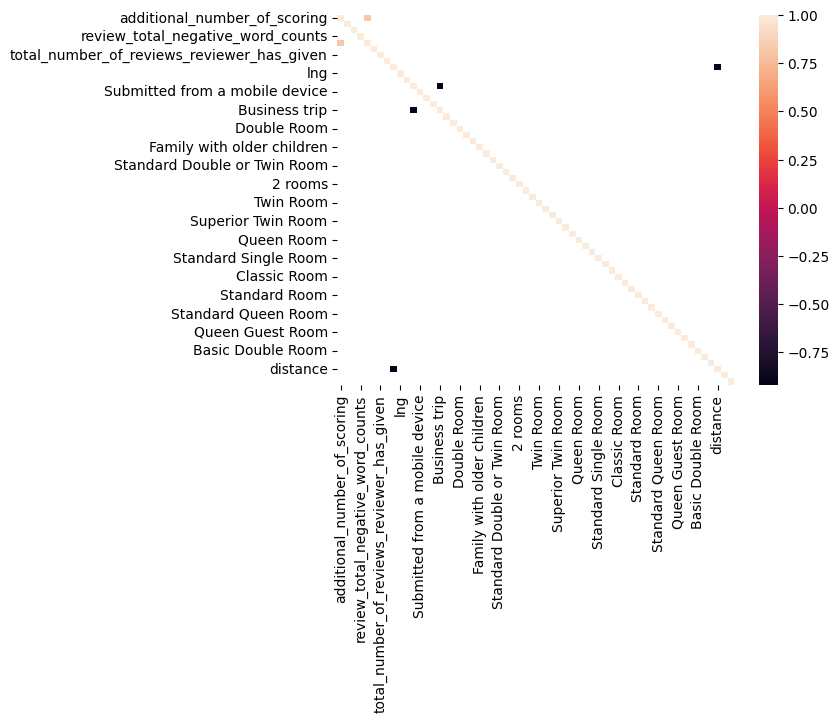

In [116]:
whole_corr = hotels.corr()[(hotels.corr() > 0.7) | (hotels.corr() < -0.7)]
sns.heatmap(whole_corr);

In [117]:
#Список фитов с мультиколлинеарностью
direct_corr = whole_corr.count(axis=0)
corr_columns = pd.DataFrame({'Name':direct_corr.index, 'CNT':direct_corr.values})
corr_columns.query("CNT > 1")

,Name,CNT
0,additional_number_of_scoring,2
4,total_number_of_reviews,2
8,lat,2
11,Leisure trip,2
15,Business trip,2
57,distance,2


In [118]:
hotels.drop(['additional_number_of_scoring', 'Business trip', 'lat'], axis=1, inplace=True)
#Дропаем столбец даты что бы модель могла работать
hotels.drop(['review_date'], axis=1, inplace=True)

---

In [119]:
#Дропаем строковые фиты
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace=True)

In [120]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

In [121]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [123]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [124]:
# Импортируем необходимые библиотеки:
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics  # инструменты для оценки точности модели

# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)


In [125]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.1352771038655127


MAPE: 0.1353280710289688